# Introduction

Kaggle Natural Language Processing with Disaster Tweets

## Competition Description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies) (Addison Howard).

## Problem
The challenge problem involves using Natural Language Processing (NLP) to classify tweets as either real disasters (labeled as '1') or not real disasters (labeled as '0'). This is a binary classification task where NLP techniques are crucial for understanding and extracting meaningful information from the unstructured text data (tweets).

This project will attempt to solve the problem using LSTM.

LSTMs are well-suited for disaster tweet classification because they effectively capture sequential patterns and dependencies in short text data, such as tweets, which often contain critical disaster-related keywords in specific orders. Their ability to retain context over sequences makes them adept at understanding the semantic meaning of phrases like "#earthquake alert" or "flood warning." LSTMs can also handle variable-length inputs (via padding), accommodating the diverse lengths of tweets while preserving important information. Additionally, their robustness to noise, when paired with proper preprocessing, allows them to focus on relevant signals in messy social media text, improving binary classification performance.

## Data Description
The training dataset (train_df) consists of 7,613 entries and 5 columns. Each entry includes an id, a keyword (a string, though 61 entries are missing), a location (a string, with a substantial 2,533 missing entries), the text of the tweet (a string), and the target (an integer indicating whether the tweet is about a real disaster, with no missing values). Similarly, the test dataset (test_df) contains 3,263 entries and 4 columns. It also includes id, keyword (with 26 missing entries), location (with 1,105 missing entries), and text. The crucial difference is the absence of the target column in the test set, as this is the variable to be predicted. Both datasets have missing values in the keyword and location columns, with location having a more significant proportion of missing data.

Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.

# Inputs

In [216]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from Levenshtein import distance
from collections import defaultdict

import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random

from sklearn.model_selection import ParameterGrid

In [217]:
data_path = './nlp-getting-started/'
for file in os.listdir(data_path):
    if file[:5]=='train':
        train_df = pd.read_csv(data_path+file)
    elif file[:4]=='test':
        test_df = pd.read_csv(data_path+file)

# EDA

In [218]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [219]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [220]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


## Missing Values

Text(0, 0.5, 'Percentage of missing values')

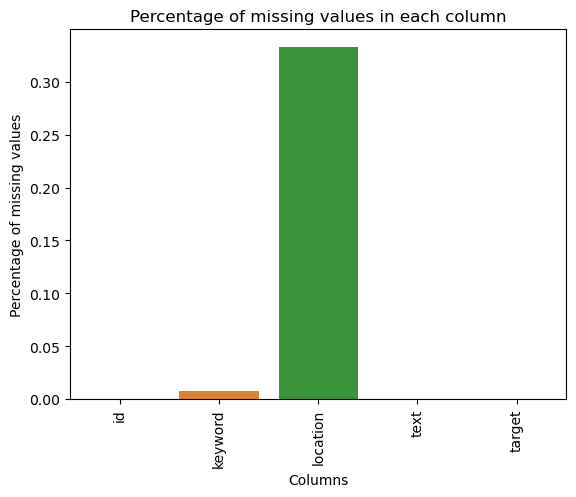

In [221]:
plt.title('Percentage of missing values in each column')
sns.barplot((train_df.isnull().sum()/len(train_df)).reset_index(), x = 'index', y = 0)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Percentage of missing values')

Text(0, 0.5, 'Percentage of missing values')

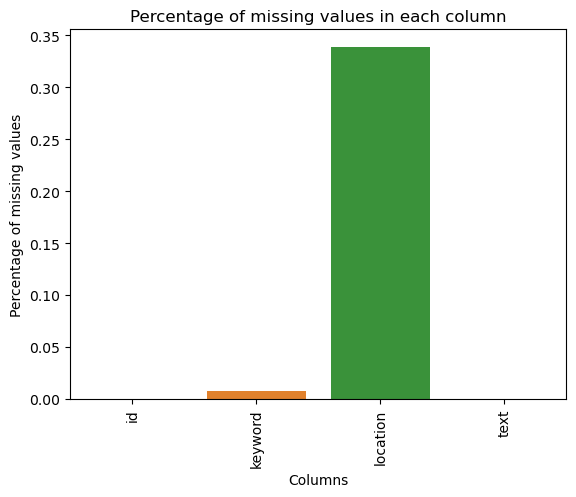

In [222]:
plt.title('Percentage of missing values in each column')
sns.barplot((test_df.isnull().sum()/len(test_df)).reset_index(), x = 'index', y = 0)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Percentage of missing values')

As expected from the data description, keyword and location contain missing values. location has over 30% missing values. These missing values will be imputed below.

## Data Preprocessing

### Imputing Missing Values

In [223]:
print('Unique keywords:', train_df['keyword'].nunique())

Unique keywords: 221


- Given the limited missing keywords, simply dropping rows might be too aggressive. 
- nokeyword will be used to impute the missing values in the keyword column.

In [224]:
train_df['keyword'] = train_df['keyword'].fillna('nokeyword')
test_df['keyword'] = test_df['keyword'].fillna('nokeyword')

In [225]:
print('Unique locations:', train_df['location'].nunique())

Unique locations: 3341


- While over 30% of the location values are missing, there are still over 3K unique locations.
- unknownlocation will be used to fill in the missing values.

In [226]:
train_df['location'] = train_df['location'].fillna('unknownlocation')
test_df['location'] = test_df['location'].fillna('unknownlocation')

### Standardization
- Keywords

In [227]:
test_df['keyword'].unique()

array(['nokeyword', 'ablaze', 'accident', 'aftershock',
       'airplane%20accident', 'ambulance', 'annihilated', 'annihilation',
       'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack',
       'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism',
       'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard',
       'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derai

The keyword column appears to be cleaned. There does appear to be very simillar words (ex. weapon and weapons, wild fires and wildfire). This will be standardized to contain the most frequent version.

In [228]:
train_df['keyword'] = train_df['keyword'].str.replace('%20', '', regex=False)
test_df['keyword'] = test_df['keyword'].str.replace('%20', '', regex=False)

In [229]:
all_keywords_series = pd.concat([test_df['keyword'], train_df['keyword']], axis = 0, ignore_index = True)
unique_keywords = all_keywords_series.unique()

keyword_counts = all_keywords_series.value_counts()
# Define similarity threshold
SIMILARITY_THRESHOLD = 0.80 # 80% similarity

canonical_map = {word: word for word in unique_keywords}
# Keep track of which words have already been processed into a group
processed_words = set()
sorted_unique_keywords = keyword_counts.index.tolist()

print(f"\nFinding similar keywords (similarity > {SIMILARITY_THRESHOLD*100}%):")
for i, word1 in enumerate(sorted_unique_keywords):
    if word1 in processed_words:
        continue # Already part of a group

    # This will be the canonical form for the current group
    # Initially, it's the word itself, but might change if a more frequent word is found
    current_canonical = word1
    group_members = [word1] # Words that are similar to word1 (including word1 itself)

    for j, word2 in enumerate(sorted_unique_keywords):
        if i >= j: # Avoid comparing a word to itself or duplicating pairs (A,B and B,A)
            continue
        if word2 in processed_words: # If word2 is already grouped, skip
            continue

        len1 = len(word1)
        len2 = len(word2)
        max_len = max(len1, len2)

        # Calculate Levenshtein distance
        lev_dist = distance(word1, word2)

        # Calculate similarity percentage
        similarity = (1 - (lev_dist / max_len)) if max_len > 0 else 1.0

        if similarity > SIMILARITY_THRESHOLD:
            # If word2 is similar to word1, add it to the group
            group_members.append(word2)

    # If a group of similar words was found (more than just word1 itself)
    if len(group_members) > 1:
        # Find the most frequent word within this group to be the canonical form
        # `key=keyword_counts.get` ensures we use the actual counts for sorting
        canonical_form = max(group_members, key=keyword_counts.get)

        print(f"  Group found. Canonical: '{canonical_form}' (Count: {keyword_counts.get(canonical_form, 0)})")
        print(f"  Members: {group_members}")

        # Update the canonical map for all members of this group
        for member_word in group_members:
            canonical_map[member_word] = canonical_form
            processed_words.add(member_word)


Finding similar keywords (similarity > 80.0%):
  Group found. Canonical: 'massmurder' (Count: 50)
  Members: ['massmurder', 'massmurderer']
  Group found. Canonical: 'obliterate' (Count: 50)
  Members: ['obliterate', 'obliterated']
  Group found. Canonical: 'quarantine' (Count: 50)
  Members: ['quarantine', 'quarantined']
  Group found. Canonical: 'ablaze' (Count: 50)
  Members: ['ablaze', 'blaze']
  Group found. Canonical: 'flood' (Count: 50)
  Members: ['flood', 'floods']
  Group found. Canonical: 'forestfires' (Count: 50)
  Members: ['forestfires', 'forestfire']
  Group found. Canonical: 'hostage' (Count: 50)
  Members: ['hostage', 'hostages']
  Group found. Canonical: 'rescued' (Count: 50)
  Members: ['rescued', 'rescue']
  Group found. Canonical: 'terrorism' (Count: 50)
  Members: ['terrorism', 'terrorist']
  Group found. Canonical: 'weapon' (Count: 50)
  Members: ['weapon', 'weapons']
  Group found. Canonical: 'wildfires' (Count: 50)
  Members: ['wildfires', 'wildfire']
  Group 

In [230]:
train_df['keyword'] = train_df['keyword'].map(canonical_map)
test_df['keyword'] = test_df['keyword'].map(canonical_map)

- Location
    - Just like the keyword column, both locations from test AND train datasets will be used prevent the out of vocabulary error.

In [231]:
train_df[train_df['location']!='unknownlocation']['location'].value_counts().nlargest(25)

USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Australia            18
Chicago, IL          18
California           17
Everywhere           15
New York, NY         15
California, USA      15
Florida              14
San Francisco        14
United Kingdom       14
Los Angeles          13
Indonesia            13
Washington, D.C.     13
Name: location, dtype: int64

In [232]:
train_df[train_df['location']!='unknownlocation']['location'].value_counts().nsmallest(25)

japon                            1
Phoenix, Arizona, USA            1
Malibu/SantaFe/Winning!          1
Bozeman, Montana                 1
McLean, VA                       1
Killa Hill, CO                   1
new york, ny                     1
Pawnee                           1
South Florida                    1
Dhaka, Bangladsh                 1
London, Greater London, UK       1
Positive 852                     1
Ashford, Kent, United Kingdom    1
Edinburgh, Scotland              1
Paris (France)                   1
Hammersmith, London              1
San Diego, Calif.                1
Kansas City, Mo.                 1
VCU                              1
Ealing, London                   1
Anywhere I like                  1
I ACCEPT SONG REQUESTS           1
USA, North Dakota                1
Norwalk, CT                      1
highlands&slands scotland        1
Name: location, dtype: int64

The location column is a bit more tricky to clean than the keyword. There does not appear to have been a standard format (ex. City, State, Country) used in this column, and there appears to even be erroneous locations like "I ACCEPT SONG REQUESTS".

In [233]:
train_df['location'] = train_df['location'].str.lower().str.strip()
test_df['location'] = test_df['location'].str.lower().str.strip()

In [234]:
all_locations_series = pd.concat([test_df['location'], train_df['location']], axis = 0, ignore_index = True)
single_loc_counts = all_locations_series.str.split(',').explode().str.strip().value_counts()

The location column will be standardized by checking each component of a comma-seperated location against the counts of single locations. The component that has the highest count will be kept, however, if a single count is less than 5, it will be replaced with 'unknownlocation'.

In [235]:
def clean_location(loc):
    # Handle missing, empty, or comma-only locations
    if pd.isna(loc) or not loc or loc.strip() == ",":
        return "unknownlocation"
    
    # Split at comma
    parts = [part.strip() for part in loc.split(",") if part.strip()]
    
    # Handle empty parts
    if not parts:
        return "unknownlocation"
    
    # Single-part or multi-part: Check counts
    for part in parts:
        if single_loc_counts.get(part, 0) >= 5:
            # For multi-part, pick part with highest count if >=5
            if len(parts) > 1:
                max_part = max(parts, key=lambda x: single_loc_counts.get(x, 0))
                if single_loc_counts.get(max_part, 0) >= 5:
                    return max_part
            # For single-part, return if count >=5
            else:
                return parts[0]
    
    # No part has count >=5
    return "unknownlocation"

In [236]:
# Apply cleaning
train_df['location'] = train_df['location'].apply(clean_location)
test_df['location'] = test_df['location'].apply(clean_location)

Lastly, we will remove any punctuations.

In [237]:
train_df['location'] = train_df['location'].str.replace('[^\w\s]','', regex = True).str.replace('\s+','', regex = True).str.strip()
test_df['location'] = test_df['location'].str.replace('[^\w\s]','', regex = True).str.replace('\s+','', regex = True).str.strip()

train_df['location'] = train_df['location'].replace('', 'unknownlocation')
test_df['location'] = test_df['location'].replace('', 'unknownlocation')

In [238]:
train_df['location'].nunique()

247

### Feature encoding
- the keyword and lcoation column will become a categorical variable (1-n)
- keyword and location from train AND test will be used to fit the LabelEncoder to ensure no out of vabulary errors.
- Note: This is NOT suitable for real-world scenarios where truly new words might appear in future data.
    - The alternative would be to handle unknown words through transformation into an unknown ID + constant retraining to ensure limited unknown IDs.

In [239]:
train_keywords = train_df['keyword'].unique()
test_keywords = test_df['keyword'].unique()
all_keywords = np.unique(np.concatenate((train_keywords, test_keywords), axis=0))

le = LabelEncoder()
le.fit(all_keywords)

# Transform both train and test keywords
train_keywords_encoded = le.transform(train_keywords)
test_keywords_encoded = le.transform(test_keywords)

# Create a mapping of keywords to their encoded labels
train_df['keyword_encoded'] = le.transform(train_df['keyword'])
test_df['keyword_encoded'] = le.transform(test_df['keyword'])

keyword_mapping = {label: keyword for keyword, label in zip(le.classes_, le.transform(le.classes_))}
sorted_mapping = sorted(keyword_mapping.items(), key=lambda item: item[1])
print(sorted_mapping[:10])

[(0, 'ablaze'), (1, 'accident'), (2, 'aftershock'), (3, 'airplaneaccident'), (4, 'ambulance'), (5, 'annihilated'), (6, 'annihilation'), (7, 'apocalypse'), (8, 'armageddon'), (9, 'army')]


In [240]:
train_locations = train_df['location'].unique()
test_locations = test_df['location'].unique()
all_locations = np.unique(np.concatenate((train_locations, test_locations), axis=0))

le = LabelEncoder()
le.fit(all_locations)

# Transform both train and test locations
train_locations_encoded = le.transform(train_locations)
test_locations_encoded = le.transform(test_locations)

# Create a mapping of locations to their encoded labels
train_df['location_encoded'] = le.transform(train_df['location'])
test_df['location_encoded'] = le.transform(test_df['location'])

location_mapping = {label: location for location, label in zip(le.classes_, le.transform(le.classes_))}
sorted_mapping = sorted(location_mapping.items(), key=lambda item: item[1])
print(sorted_mapping[:10])

[(0, '304'), (1, 'abuja'), (2, 'adelaide'), (3, 'africa'), (4, 'ak'), (5, 'al'), (6, 'alabama'), (7, 'alaska'), (8, 'alberta'), (9, 'alexandria')]


### Top keywords and locations per label

In [241]:
train_df['location_encoded'] = pd.Categorical(train_df['location_encoded'])
train_df['keyword_encoded'] = pd.Categorical(train_df['keyword_encoded'])

test_df['location_encoded'] = pd.Categorical(test_df['location_encoded'])
test_df['keyword_encoded'] = pd.Categorical(test_df['keyword_encoded'])

<Axes: xlabel='location_encoded', ylabel='Count'>

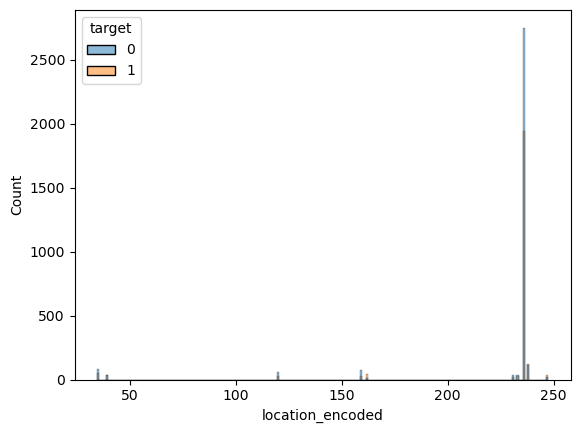

In [242]:
sns.histplot(train_df[train_df['location_encoded'].isin(train_df['location_encoded'].value_counts().nlargest(10).index)],
             x = 'location_encoded', hue = 'target')

In [243]:
top_10_locations = pd.concat([train_df[(train_df['target']==0)&(train_df['location_encoded']!= 'unknownlocation')]['location_encoded'].value_counts().nlargest(10).reset_index(),
train_df[(train_df['target']==1)&(train_df['location_encoded']!= 'unknownlocation')]['location_encoded'].value_counts().nlargest(10).reset_index()], axis = 1)
top_10_locations.columns = ['location_target_0', 'count_0', 'location_target_1', 'count_1']
top_10_locations

,location_target_0,count_0,location_target_1,count_1
0,236,2750,236,1941
1,238,115,238,119
2,35,80,35,51
3,159,74,162,42
4,120,57,39,36
5,233,35,91,33
6,39,34,247,32
7,231,34,120,31
8,61,31,159,29
9,66,30,235,28


Unsurprisingly, the location feature has a decent amount of overlap within the top 10. From this, and the number of missing values, we hypothesize that this feature does not have strong predictive power.

<Axes: xlabel='keyword_encoded', ylabel='Count'>

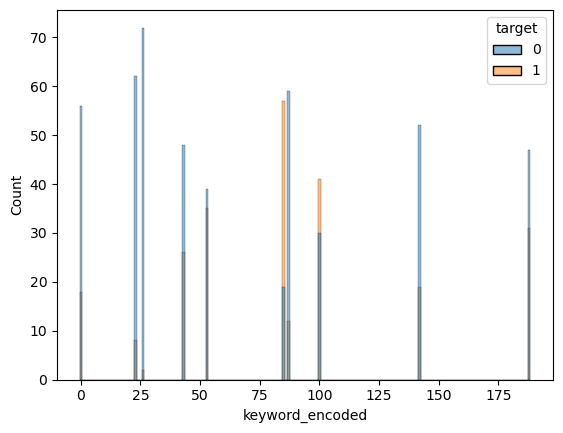

In [244]:
sns.histplot(train_df[train_df['keyword_encoded'].isin(train_df['keyword_encoded'].value_counts().nlargest(10).index)],
             x = 'keyword_encoded', hue = 'target')

In [245]:
top_10_keywords = pd.concat([train_df[(train_df['target']==0)&(train_df['keyword_encoded']!= 'unknownlocation')]['keyword_encoded'].value_counts().nlargest(10).reset_index(),
train_df[(train_df['target']==1)&(train_df['keyword_encoded']!= 'unknownlocation')]['keyword_encoded'].value_counts().nlargest(10).reset_index()], axis = 1)
top_10_keywords.columns = ['keyword_target_0', 'count_0', 'keyword_target_1', 'count_1']
top_10_keywords

,keyword_target_0,count_0,keyword_target_1,count_1
0,26,72,166,62
1,23,62,85,57
2,87,59,190,56
3,160,57,171,47
4,55,56,125,47
5,0,56,113,42
6,134,54,102,42
7,142,52,131,42
8,79,52,100,41
9,169,50,137,39


Unliked the location feature, the keyword feature shows a decent amount of seperation between labels. From this, we can hypothesize that the keyword feature has decent predictive power.

In [246]:
train_cat = train_df[['location_encoded','keyword_encoded']].values
test_cat = test_df[['location_encoded','keyword_encoded']].values

### NLP on text field
- Tokenizer will be used on the train set with OOV to handle out of vocabulary words
- Remove url and mentions
- Keep hashtags to help with disaster event identification
- Preserve stop words to help with context in short tweets
- Robust to emoji and special charecters and normalizes for tokenization

In [247]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Lowercase
    text = text.lower()
    # Remove URLs (replace with 'url' or '')
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    # Remove excessive punctuation, keep hashtags and basic punctuation
    text = re.sub(r'[^\w\s#]', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [248]:
train_df['text_cleaned'] = train_df['text'].apply(preprocess_text)

In [249]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text_cleaned'])
total_vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token

In [250]:
total_vocab_size

15873

In [251]:
print(train_df['text_cleaned'].str.split().str.len().mean())

13.680546433731775


In [252]:
max_words = 5000  # Vocabulary size (top 5000 words)
max_len = 30      # Maximum sequence length (tweets are short)

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text_cleaned'])
train_sequences = tokenizer.texts_to_sequences(train_df['text_cleaned'])
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')


test_df['text_cleaned'] = test_df['text'].apply(preprocess_text)
test_sequences = tokenizer.texts_to_sequences(test_df['text_cleaned'])
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

## Label Distribution

([<matplotlib.axis.XTick at 0x7fb4f9bafe20>,
 [Text(0, 0, 'Non-Disaster'), Text(1, 0, 'Disaster')])

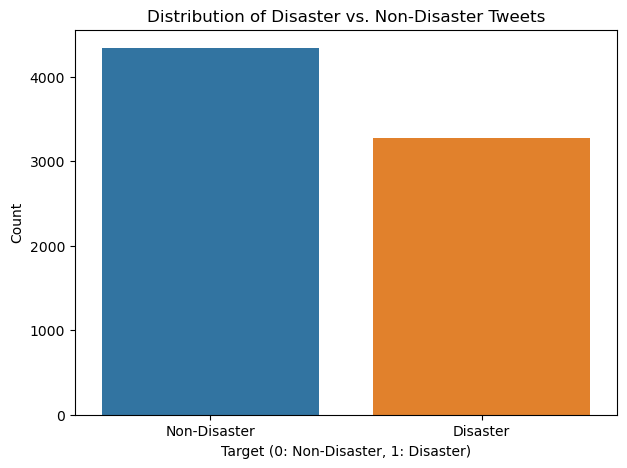

In [253]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train_df, x='target')
plt.title('Distribution of Disaster vs. Non-Disaster Tweets')
plt.xlabel('Target (0: Non-Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])

Surprisingly, the labels are evenly distributed. This allows for simple training data architecture without more complicated synthetic training sets (ex. SMOTE, over or under sampling)

# Model Architecture

LSTM
- Well suited for sequential patterns and dependencies in short text data
    - words in specific order could be important in tweets
- Ability to retain context over sequences to better understand semantic meaning of phrases
- Padding allows for variable length inputs

## Base Model
- Multi-input text sequence + dense branch
- embedding layer of 64 dimension
- LSTM 32 layer (tanh activation) for padded text
- Dense layer 16 for categorical features
- Single sigmoid output
- Adam optimizer, binary cross entropy loss, and accuracy metric
- Early stopping 5 (epochs 50)
- batch size 64

In [254]:
print('''
Custom F1 score function that could be used:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binary predictions
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()
''')


Custom F1 score function that could be used:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binary predictions
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()



In [255]:
text_input = Input(shape=(max_len,), name='text_input')
text_embed = Embedding(max_words, 64, input_length=max_len)(text_input)
text_lstm = LSTM(32)(text_embed)
cat_input = Input(shape=(train_cat.shape[1],), name='cat_input')
cat_dense = Dense(16, activation='relu')(cat_input)
combined = Concatenate()([text_lstm, cat_dense])
output = Dense(16, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(output)
model = Model(inputs=[text_input, cat_input], outputs=output)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    #metrics=['accuracy', F1Score()]
    metrics = 'accuracy'
)

early_stopping = EarlyStopping(
    #monitor='val_f1_score',    
    monitor='val_accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=0
)
checkpoint = ModelCheckpoint(
    'best_model',
    #monitor='val_f1_score',
    monitor = 'val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=0
)

history = model.fit(
    [train_padded, train_cat],
    train_df['target'].values,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=1,
    shuffle = False
)


Epoch 1/50
94/96 [============================>.] - ETA: 0s - loss: 6.6486 - accuracy: 0.5537INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


96/96 [==============================] - 9s 63ms/step - loss: 6.5799 - accuracy: 0.5522 - val_loss: 1.1453 - val_accuracy: 0.5437
Epoch 2/50
95/96 [============================>.] - ETA: 0s - loss: 1.2818 - accuracy: 0.5275INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


96/96 [==============================] - 6s 64ms/step - loss: 1.2812 - accuracy: 0.5274 - val_loss: 0.9786 - val_accuracy: 0.5502
Epoch 3/50
96/96 [==============================] - 2s 18ms/step - loss: 0.9861 - accuracy: 0.4846 - val_loss: 0.9459 - val_accuracy: 0.5502
Epoch 4/50
96/96 [==============================] - 2s 21ms/step - loss: 0.9126 - accuracy: 0.4913 - val_loss: 0.8490 - val_accuracy: 0.5502
Epoch 5/50
96/96 [==============================] - 2s 23ms/step - loss: 0.8537 - accuracy: 0.5110 - val_loss: 0.7641 - val_accuracy: 0.5437
Epoch 6/50
96/96 [==============================] - ETA: 0s - loss: 0.5970 - accuracy: 0.7401INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


96/96 [==============================] - 5s 54ms/step - loss: 0.5970 - accuracy: 0.7401 - val_loss: 0.5860 - val_accuracy: 0.7420
Epoch 7/50
96/96 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.8424INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


96/96 [==============================] - 5s 55ms/step - loss: 0.4236 - accuracy: 0.8424 - val_loss: 0.5507 - val_accuracy: 0.7597
Epoch 8/50
93/96 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8852INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


96/96 [==============================] - 5s 55ms/step - loss: 0.3398 - accuracy: 0.8854 - val_loss: 0.5387 - val_accuracy: 0.7774
Epoch 9/50
96/96 [==============================] - 2s 18ms/step - loss: 0.3168 - accuracy: 0.9005 - val_loss: 0.6281 - val_accuracy: 0.7328
Epoch 10/50
96/96 [==============================] - 2s 21ms/step - loss: 0.3069 - accuracy: 0.9107 - val_loss: 0.6247 - val_accuracy: 0.7636
Epoch 11/50
96/96 [==============================] - 2s 19ms/step - loss: 0.3073 - accuracy: 0.9143 - val_loss: 0.7208 - val_accuracy: 0.7748
Epoch 12/50
96/96 [==============================] - 2s 21ms/step - loss: 0.2797 - accuracy: 0.9192 - val_loss: 0.9125 - val_accuracy: 0.7354
Epoch 13/50
96/96 [==============================] - 2s 20ms/step - loss: 0.2877 - accuracy: 0.9250 - val_loss: 0.6847 - val_accuracy: 0.7538


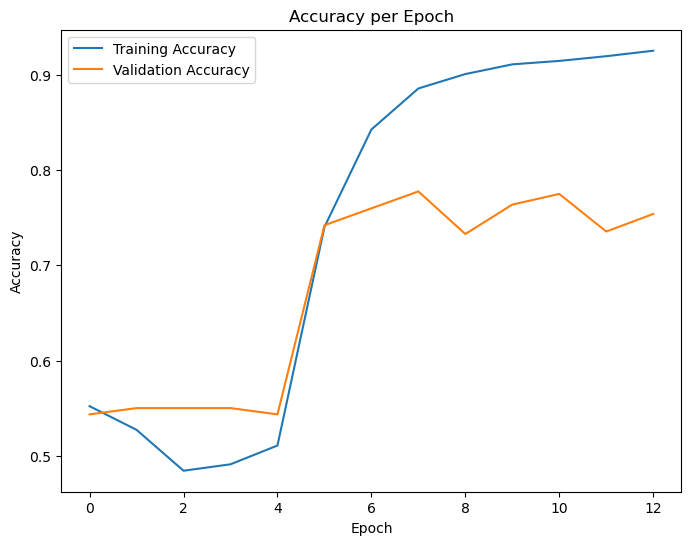

In [256]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [257]:
n_samples = len(train_df)
val_size = int(0.2 * n_samples)
train_size = n_samples - val_size

train_indices = np.arange(train_size)
val_indices = np.arange(train_size, n_samples)

train_padded_split = train_padded[train_indices]
train_cat_split = train_cat[train_indices]
train_labels = train_df['target'].values[train_indices]

val_padded_split = train_padded[val_indices]
val_cat_split = train_cat[val_indices]
val_labels = train_df['target'].values[val_indices]

train_preds = (model.predict([train_padded_split, train_cat_split]) > 0.5).astype(int)
val_preds = (model.predict([val_padded_split, val_cat_split]) > 0.5).astype(int)

print("\nTraining Confusion Matrix:")
print(confusion_matrix(train_labels, train_preds))
print("\nTraining Classification Report:")
print(classification_report(train_labels, train_preds, target_names=['Non-Disaster', 'Disaster']))

print("\nValidation Confusion Matrix:")
print(confusion_matrix(val_labels, val_preds))
print("\nValidation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['Non-Disaster', 'Disaster']))

train_metrics = {
    'F1': f1_score(train_labels, train_preds),
    'Accuracy': accuracy_score(train_labels, train_preds),
    'Precision': precision_score(train_labels, train_preds),
    'Recall': recall_score(train_labels, train_preds)
}
val_metrics = {
    'F1': f1_score(val_labels, val_preds),
    'Accuracy': accuracy_score(val_labels, val_preds),
    'Precision': precision_score(val_labels, val_preds),
    'Recall': recall_score(val_labels, val_preds)
}

print("\nTraining Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nValidation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

48/48 [==============================] - 0s 5ms/step

Training Confusion Matrix:
[[3422  107]
 [ 550 2012]]

Training Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.86      0.97      0.91      3529
    Disaster       0.95      0.79      0.86      2562

    accuracy                           0.89      6091
   macro avg       0.91      0.88      0.89      6091
weighted avg       0.90      0.89      0.89      6091


Validation Confusion Matrix:
[[719  94]
 [245 464]]

Validation Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.75      0.88      0.81       813
    Disaster       0.83      0.65      0.73       709

    accuracy                           0.78      1522
   macro avg       0.79      0.77      0.77      1522
weighted avg       0.79      0.78      0.77      1522


Training Metrics:
F1: 0.8596
Accuracy: 0.8921
Precision: 0.9495
Recall: 0.7853

Validation Metrics:
F1: 0.7324
Accur

The base model is struggling with some overfitting, seen by the learning curves and the gap (~8%) in f1 score between training and validation. Some potential reasons for overfitting:
- relatively small data set
- lack of sufficient regularization (no drop out of L2)
- lack of class weights

However, the gap does not appear to be too large. A gridsearch will now be conducted to try and improve val f1 score.

## GridSearch
- Batch Size: 32, 64
- Embedding Dimension: 32, 64
- Learning Rate: .001, .0005, .0001

In [264]:
param_grid = {
    'batch_size': [32, 64],
    'embedding_dim': [32, 64],
    'learning_rate': [0.001, 0.0005, 0.0001],
}

In [265]:
results_df = pd.DataFrame(columns=[
    'batch_size', 'embedding_dim', 'learning_rate',
    'train_f1', 'train_accuracy', 'train_precision', 'train_recall',
    'val_f1', 'val_accuracy', 'val_precision', 'val_recall', 'f1_gap'
])

# Grid search
best_val_f1 = 0.0
best_params = None
best_model_path = 'best_model_grid'
best_history = None

for params in ParameterGrid(param_grid):
    print(f"\nTesting parameters: {params}")
    
    # Model architecture
    text_input = Input(shape=(max_len,), name='text_input')
    text_embed = Embedding(max_words, params['embedding_dim'], input_length=max_len)(text_input)
    text_lstm = LSTM(32)(text_embed)
    cat_input = Input(shape=(train_cat.shape[1],), name='cat_input')
    cat_dense = Dense(16, activation='relu')(cat_input)
    combined = Concatenate()([text_lstm, cat_dense])
    output = Dense(16, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(output)
    model = Model(inputs=[text_input, cat_input], outputs=output)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics='accuracy'
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
    checkpoint = ModelCheckpoint(
        f"model_{params['batch_size']}_{params['embedding_dim']}_{params['learning_rate']}",
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=0
    )

    # Train model
    history = model.fit(
        [train_padded, train_cat],
        train_df['target'].values,
        epochs=50,
        batch_size=params['batch_size'],
        validation_split=0.2,
        callbacks=[early_stopping, checkpoint],
        shuffle=False,
        verbose=1
    )
    n_samples = len(train_df)
    val_size = int(0.2 * n_samples)
    train_size = n_samples - val_size
    train_indices = np.arange(train_size)
    val_indices = np.arange(train_size, n_samples)
    train_padded_split = train_padded[train_indices]
    train_cat_split = train_cat[train_indices]
    train_labels = train_df['target'].values[train_indices]
    val_padded_split = train_padded[val_indices]
    val_cat_split = train_cat[val_indices]
    val_labels = train_df['target'].values[val_indices]

    train_preds = (model.predict([train_padded_split, train_cat_split]) > 0.5).astype(int)
    val_preds = (model.predict([val_padded_split, val_cat_split]) > 0.5).astype(int)

    train_f1 = f1_score(train_labels, train_preds)
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_precision = precision_score(train_labels, train_preds)
    train_recall = recall_score(train_labels, train_preds)
    val_f1 = f1_score(val_labels, val_preds)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    f1_gap = train_f1 - val_f1

    # Store results
    results_df = pd.concat([results_df, pd.DataFrame([{
        'batch_size': params['batch_size'],
        'embedding_dim': params['embedding_dim'],
        'learning_rate': params['learning_rate'],
        'train_f1': train_f1,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'val_f1': val_f1,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'f1_gap': f1_gap
    }])], ignore_index=True)

    print(f"Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}, F1 Gap: {(train_f1 - val_f1):.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_params = params
        best_history = history
        model.save(best_model_path)



Testing parameters: {'batch_size': 32, 'embedding_dim': 32, 'learning_rate': 0.001}
Epoch 1/50
190/191 [============================>.] - ETA: 0s - loss: 0.8191 - accuracy: 0.5118INFO:tensorflow:Assets written to: model_32_32_0.001/assets


INFO:tensorflow:Assets written to: model_32_32_0.001/assets


191/191 [==============================] - 17s 63ms/step - loss: 0.8196 - accuracy: 0.5118 - val_loss: 1.2730 - val_accuracy: 0.5345
Epoch 2/50
191/191 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.6542INFO:tensorflow:Assets written to: model_32_32_0.001/assets


INFO:tensorflow:Assets written to: model_32_32_0.001/assets


191/191 [==============================] - 12s 63ms/step - loss: 0.7079 - accuracy: 0.6542 - val_loss: 0.6644 - val_accuracy: 0.7308
Epoch 3/50
190/191 [============================>.] - ETA: 0s - loss: 0.4637 - accuracy: 0.8061INFO:tensorflow:Assets written to: model_32_32_0.001/assets


INFO:tensorflow:Assets written to: model_32_32_0.001/assets


191/191 [==============================] - 11s 58ms/step - loss: 0.4631 - accuracy: 0.8064 - val_loss: 0.6458 - val_accuracy: 0.7886
Epoch 4/50
191/191 [==============================] - 3s 17ms/step - loss: 0.3679 - accuracy: 0.8655 - val_loss: 0.6411 - val_accuracy: 0.7649
Epoch 5/50
191/191 [==============================] - 4s 19ms/step - loss: 0.3724 - accuracy: 0.8654 - val_loss: 0.7050 - val_accuracy: 0.7557
Epoch 6/50
191/191 [==============================] - 3s 17ms/step - loss: 0.3008 - accuracy: 0.8985 - val_loss: 0.6328 - val_accuracy: 0.7741
Epoch 7/50
191/191 [==============================] - 4s 19ms/step - loss: 0.2624 - accuracy: 0.9204 - val_loss: 0.6907 - val_accuracy: 0.7695
Epoch 8/50
48/48 [==============================] - 0s 5ms/step
Training F1: 0.8074, Validation F1: 0.7424, F1 Gap: 0.0650
INFO:tensorflow:Assets written to: best_model_grid/assets


INFO:tensorflow:Assets written to: best_model_grid/assets



Testing parameters: {'batch_size': 32, 'embedding_dim': 32, 'learning_rate': 0.0005}
Epoch 1/50
191/191 [==============================] - ETA: 0s - loss: 0.8209 - accuracy: 0.5067INFO:tensorflow:Assets written to: model_32_32_0.0005/assets


INFO:tensorflow:Assets written to: model_32_32_0.0005/assets


191/191 [==============================] - 11s 43ms/step - loss: 0.8209 - accuracy: 0.5067 - val_loss: 0.9706 - val_accuracy: 0.5332
Epoch 2/50
190/191 [============================>.] - ETA: 0s - loss: 0.9024 - accuracy: 0.4852INFO:tensorflow:Assets written to: model_32_32_0.0005/assets


INFO:tensorflow:Assets written to: model_32_32_0.0005/assets


191/191 [==============================] - 7s 38ms/step - loss: 0.9022 - accuracy: 0.4852 - val_loss: 0.9018 - val_accuracy: 0.5345
Epoch 3/50
190/191 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.6831INFO:tensorflow:Assets written to: model_32_32_0.0005/assets


INFO:tensorflow:Assets written to: model_32_32_0.0005/assets


191/191 [==============================] - 7s 35ms/step - loss: 0.6917 - accuracy: 0.6836 - val_loss: 0.5192 - val_accuracy: 0.7722
Epoch 4/50
190/191 [============================>.] - ETA: 0s - loss: 0.4148 - accuracy: 0.8342INFO:tensorflow:Assets written to: model_32_32_0.0005/assets


INFO:tensorflow:Assets written to: model_32_32_0.0005/assets


191/191 [==============================] - 7s 37ms/step - loss: 0.4143 - accuracy: 0.8345 - val_loss: 0.5190 - val_accuracy: 0.7768
Epoch 5/50
191/191 [==============================] - 3s 18ms/step - loss: 0.3251 - accuracy: 0.8806 - val_loss: 0.7813 - val_accuracy: 0.7360
Epoch 6/50
191/191 [==============================] - 3s 18ms/step - loss: 0.2975 - accuracy: 0.8939 - val_loss: 0.6355 - val_accuracy: 0.7505
Epoch 7/50
191/191 [==============================] - 3s 18ms/step - loss: 0.2663 - accuracy: 0.9074 - val_loss: 0.5957 - val_accuracy: 0.7702
Epoch 8/50
191/191 [==============================] - 3s 17ms/step - loss: 0.2459 - accuracy: 0.9154 - val_loss: 0.6479 - val_accuracy: 0.7722
Epoch 9/50
48/48 [==============================] - 0s 6ms/step
Training F1: 0.8486, Validation F1: 0.7580, F1 Gap: 0.0906
INFO:tensorflow:Assets written to: best_model_grid/assets


INFO:tensorflow:Assets written to: best_model_grid/assets



Testing parameters: {'batch_size': 32, 'embedding_dim': 32, 'learning_rate': 0.0001}
Epoch 1/50
191/191 [==============================] - ETA: 0s - loss: 5.2527 - accuracy: 0.5562INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


191/191 [==============================] - 10s 36ms/step - loss: 5.2527 - accuracy: 0.5562 - val_loss: 0.9185 - val_accuracy: 0.4747
Epoch 2/50
189/191 [============================>.] - ETA: 0s - loss: 1.8541 - accuracy: 0.5263INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


191/191 [==============================] - 8s 42ms/step - loss: 1.8465 - accuracy: 0.5259 - val_loss: 0.7635 - val_accuracy: 0.5213
Epoch 3/50
190/191 [============================>.] - ETA: 0s - loss: 1.3190 - accuracy: 0.5038INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


191/191 [==============================] - 7s 36ms/step - loss: 1.3181 - accuracy: 0.5038 - val_loss: 0.7402 - val_accuracy: 0.5279
Epoch 4/50
189/191 [============================>.] - ETA: 0s - loss: 1.0303 - accuracy: 0.5103INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


191/191 [==============================] - 7s 36ms/step - loss: 1.0283 - accuracy: 0.5092 - val_loss: 0.7234 - val_accuracy: 0.5345
Epoch 5/50
191/191 [==============================] - 3s 17ms/step - loss: 0.8573 - accuracy: 0.5381 - val_loss: 0.7274 - val_accuracy: 0.5345
Epoch 6/50
190/191 [============================>.] - ETA: 0s - loss: 0.7734 - accuracy: 0.5345INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


191/191 [==============================] - 7s 35ms/step - loss: 0.7733 - accuracy: 0.5345 - val_loss: 0.7318 - val_accuracy: 0.5351
Epoch 7/50
190/191 [============================>.] - ETA: 0s - loss: 0.7278 - accuracy: 0.5521INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


191/191 [==============================] - 7s 36ms/step - loss: 0.7277 - accuracy: 0.5522 - val_loss: 0.7220 - val_accuracy: 0.5437
Epoch 8/50
190/191 [============================>.] - ETA: 0s - loss: 0.5840 - accuracy: 0.7113INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


191/191 [==============================] - 8s 41ms/step - loss: 0.5834 - accuracy: 0.7118 - val_loss: 0.5241 - val_accuracy: 0.7623
Epoch 9/50
188/191 [============================>.] - ETA: 0s - loss: 0.4257 - accuracy: 0.8290INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


191/191 [==============================] - 7s 37ms/step - loss: 0.4250 - accuracy: 0.8294 - val_loss: 0.5102 - val_accuracy: 0.7689
Epoch 10/50
189/191 [============================>.] - ETA: 0s - loss: 0.3745 - accuracy: 0.8590INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


INFO:tensorflow:Assets written to: model_32_32_0.0001/assets


191/191 [==============================] - 7s 35ms/step - loss: 0.3735 - accuracy: 0.8594 - val_loss: 0.5135 - val_accuracy: 0.7728
Epoch 11/50
191/191 [==============================] - 3s 17ms/step - loss: 0.3358 - accuracy: 0.8770 - val_loss: 0.5272 - val_accuracy: 0.7728
Epoch 12/50
191/191 [==============================] - 4s 19ms/step - loss: 0.3050 - accuracy: 0.8923 - val_loss: 0.5551 - val_accuracy: 0.7630
Epoch 13/50
191/191 [==============================] - 3s 17ms/step - loss: 0.2758 - accuracy: 0.9067 - val_loss: 0.5704 - val_accuracy: 0.7663
Epoch 14/50
191/191 [==============================] - 3s 18ms/step - loss: 0.2553 - accuracy: 0.9186 - val_loss: 0.6135 - val_accuracy: 0.7571
Epoch 15/50
48/48 [==============================] - 1s 10ms/step
Training F1: 0.8444, Validation F1: 0.7422, F1 Gap: 0.1023

Testing parameters: {'batch_size': 32, 'embedding_dim': 64, 'learning_rate': 0.001}
Epoch 1/50
190/191 [============================>.] - ETA: 0s - loss: 1.0403 - acc

INFO:tensorflow:Assets written to: model_32_64_0.001/assets


191/191 [==============================] - 11s 42ms/step - loss: 1.0406 - accuracy: 0.5437 - val_loss: 0.9878 - val_accuracy: 0.5522
Epoch 2/50
191/191 [==============================] - 4s 20ms/step - loss: 0.7348 - accuracy: 0.5179 - val_loss: 0.8290 - val_accuracy: 0.5391
Epoch 3/50
191/191 [==============================] - 4s 20ms/step - loss: 0.7138 - accuracy: 0.5381 - val_loss: 0.7687 - val_accuracy: 0.5391
Epoch 4/50
191/191 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.5658INFO:tensorflow:Assets written to: model_32_64_0.001/assets


INFO:tensorflow:Assets written to: model_32_64_0.001/assets


191/191 [==============================] - 7s 38ms/step - loss: 0.6974 - accuracy: 0.5658 - val_loss: 0.7870 - val_accuracy: 0.6080
Epoch 5/50
191/191 [==============================] - 4s 19ms/step - loss: 0.6820 - accuracy: 0.5913 - val_loss: 0.8548 - val_accuracy: 0.5456
Epoch 6/50
190/191 [============================>.] - ETA: 0s - loss: 0.6561 - accuracy: 0.6367INFO:tensorflow:Assets written to: model_32_64_0.001/assets


INFO:tensorflow:Assets written to: model_32_64_0.001/assets


191/191 [==============================] - 8s 44ms/step - loss: 0.6560 - accuracy: 0.6369 - val_loss: 0.6800 - val_accuracy: 0.6251
Epoch 7/50
189/191 [============================>.] - ETA: 0s - loss: 0.5911 - accuracy: 0.7206INFO:tensorflow:Assets written to: model_32_64_0.001/assets


INFO:tensorflow:Assets written to: model_32_64_0.001/assets


191/191 [==============================] - 8s 44ms/step - loss: 0.5899 - accuracy: 0.7218 - val_loss: 0.6608 - val_accuracy: 0.6934
Epoch 8/50
191/191 [==============================] - 4s 19ms/step - loss: 0.5812 - accuracy: 0.7343 - val_loss: 0.7301 - val_accuracy: 0.6087
Epoch 9/50
191/191 [==============================] - 4s 22ms/step - loss: 0.5737 - accuracy: 0.7314 - val_loss: 0.7199 - val_accuracy: 0.6034
Epoch 10/50
191/191 [==============================] - 4s 22ms/step - loss: 0.5579 - accuracy: 0.7450 - val_loss: 0.7212 - val_accuracy: 0.6100
Epoch 11/50
191/191 [==============================] - 5s 24ms/step - loss: 0.5484 - accuracy: 0.7511 - val_loss: 0.6888 - val_accuracy: 0.6376
Epoch 12/50
48/48 [==============================] - 0s 6ms/step
Training F1: 0.7287, Validation F1: 0.6905, F1 Gap: 0.0382

Testing parameters: {'batch_size': 32, 'embedding_dim': 64, 'learning_rate': 0.0005}
Epoch 1/50
190/191 [============================>.] - ETA: 0s - loss: 1.7723 - accur

INFO:tensorflow:Assets written to: model_32_64_0.0005/assets


191/191 [==============================] - 11s 43ms/step - loss: 1.7709 - accuracy: 0.5207 - val_loss: 0.9222 - val_accuracy: 0.5345
Epoch 2/50
191/191 [==============================] - 4s 21ms/step - loss: 0.9682 - accuracy: 0.4897 - val_loss: 0.9711 - val_accuracy: 0.5345
Epoch 3/50
190/191 [============================>.] - ETA: 0s - loss: 0.7599 - accuracy: 0.6408INFO:tensorflow:Assets written to: model_32_64_0.0005/assets


INFO:tensorflow:Assets written to: model_32_64_0.0005/assets


191/191 [==============================] - 8s 40ms/step - loss: 0.7590 - accuracy: 0.6414 - val_loss: 0.5344 - val_accuracy: 0.7774
Epoch 4/50
189/191 [============================>.] - ETA: 0s - loss: 0.4623 - accuracy: 0.8261INFO:tensorflow:Assets written to: model_32_64_0.0005/assets


INFO:tensorflow:Assets written to: model_32_64_0.0005/assets


191/191 [==============================] - 8s 39ms/step - loss: 0.4611 - accuracy: 0.8264 - val_loss: 0.4854 - val_accuracy: 0.7899
Epoch 5/50
191/191 [==============================] - 4s 20ms/step - loss: 0.3428 - accuracy: 0.8722 - val_loss: 0.6233 - val_accuracy: 0.7544
Epoch 6/50
191/191 [==============================] - 4s 22ms/step - loss: 0.2993 - accuracy: 0.8990 - val_loss: 0.6299 - val_accuracy: 0.7722
Epoch 7/50
191/191 [==============================] - 4s 20ms/step - loss: 0.2811 - accuracy: 0.9097 - val_loss: 0.7116 - val_accuracy: 0.7879
Epoch 8/50
191/191 [==============================] - 4s 18ms/step - loss: 0.2425 - accuracy: 0.9279 - val_loss: 0.6243 - val_accuracy: 0.7807
Epoch 9/50
48/48 [==============================] - 0s 5ms/step
Training F1: 0.8205, Validation F1: 0.7647, F1 Gap: 0.0558
INFO:tensorflow:Assets written to: best_model_grid/assets


INFO:tensorflow:Assets written to: best_model_grid/assets



Testing parameters: {'batch_size': 32, 'embedding_dim': 64, 'learning_rate': 0.0001}
Epoch 1/50
189/191 [============================>.] - ETA: 0s - loss: 24.3697 - accuracy: 0.4190INFO:tensorflow:Assets written to: model_32_64_0.0001/assets


INFO:tensorflow:Assets written to: model_32_64_0.0001/assets


191/191 [==============================] - 13s 41ms/step - loss: 24.2547 - accuracy: 0.4205 - val_loss: 10.8648 - val_accuracy: 0.4767
Epoch 2/50
189/191 [============================>.] - ETA: 0s - loss: 9.1986 - accuracy: 0.4418INFO:tensorflow:Assets written to: model_32_64_0.0001/assets


INFO:tensorflow:Assets written to: model_32_64_0.0001/assets


191/191 [==============================] - 8s 41ms/step - loss: 9.1525 - accuracy: 0.4412 - val_loss: 2.4059 - val_accuracy: 0.5502
Epoch 3/50
190/191 [============================>.] - ETA: 0s - loss: 2.4705 - accuracy: 0.4944INFO:tensorflow:Assets written to: model_32_64_0.0001/assets


INFO:tensorflow:Assets written to: model_32_64_0.0001/assets


191/191 [==============================] - 8s 41ms/step - loss: 2.4685 - accuracy: 0.4944 - val_loss: 0.9556 - val_accuracy: 0.5548
Epoch 4/50
191/191 [==============================] - 4s 20ms/step - loss: 1.5063 - accuracy: 0.4898 - val_loss: 0.9027 - val_accuracy: 0.4754
Epoch 5/50
191/191 [==============================] - 4s 21ms/step - loss: 1.0489 - accuracy: 0.5031 - val_loss: 0.8728 - val_accuracy: 0.5121
Epoch 6/50
191/191 [==============================] - 4s 20ms/step - loss: 0.9167 - accuracy: 0.5046 - val_loss: 0.8552 - val_accuracy: 0.5115
Epoch 7/50
191/191 [==============================] - 4s 20ms/step - loss: 0.8634 - accuracy: 0.5064 - val_loss: 0.8432 - val_accuracy: 0.5076
Epoch 8/50
48/48 [==============================] - 0s 6ms/step
Training F1: 0.5355, Validation F1: 0.1008, F1 Gap: 0.4347

Testing parameters: {'batch_size': 64, 'embedding_dim': 32, 'learning_rate': 0.001}
Epoch 1/50
95/96 [============================>.] - ETA: 0s - loss: 3.6597 - accuracy: 0

INFO:tensorflow:Assets written to: model_64_32_0.001/assets


96/96 [==============================] - 9s 61ms/step - loss: 3.6548 - accuracy: 0.5374 - val_loss: 0.7558 - val_accuracy: 0.5476
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 1.2960 - accuracy: 0.5120INFO:tensorflow:Assets written to: model_64_32_0.001/assets


INFO:tensorflow:Assets written to: model_64_32_0.001/assets


96/96 [==============================] - 7s 74ms/step - loss: 1.2960 - accuracy: 0.5120 - val_loss: 0.7663 - val_accuracy: 0.5522
Epoch 3/50
96/96 [==============================] - 2s 21ms/step - loss: 1.1186 - accuracy: 0.4998 - val_loss: 0.7231 - val_accuracy: 0.5502
Epoch 4/50
96/96 [==============================] - 2s 20ms/step - loss: 1.0019 - accuracy: 0.5222 - val_loss: 0.7087 - val_accuracy: 0.5279
Epoch 5/50
96/96 [==============================] - 2s 20ms/step - loss: 0.9225 - accuracy: 0.5199 - val_loss: 0.7199 - val_accuracy: 0.5279
Epoch 6/50
94/96 [============================>.] - ETA: 0s - loss: 0.8638 - accuracy: 0.5349INFO:tensorflow:Assets written to: model_64_32_0.001/assets


INFO:tensorflow:Assets written to: model_64_32_0.001/assets


96/96 [==============================] - 6s 66ms/step - loss: 0.8601 - accuracy: 0.5373 - val_loss: 0.6908 - val_accuracy: 0.6218
Epoch 7/50
93/96 [============================>.] - ETA: 0s - loss: 0.6536 - accuracy: 0.6803INFO:tensorflow:Assets written to: model_64_32_0.001/assets


INFO:tensorflow:Assets written to: model_64_32_0.001/assets


96/96 [==============================] - 5s 56ms/step - loss: 0.6486 - accuracy: 0.6841 - val_loss: 0.6377 - val_accuracy: 0.6986
Epoch 8/50
93/96 [============================>.] - ETA: 0s - loss: 0.5356 - accuracy: 0.7762INFO:tensorflow:Assets written to: model_64_32_0.001/assets


INFO:tensorflow:Assets written to: model_64_32_0.001/assets


96/96 [==============================] - 6s 62ms/step - loss: 0.5318 - accuracy: 0.7785 - val_loss: 0.5684 - val_accuracy: 0.7387
Epoch 9/50
96/96 [==============================] - 2s 22ms/step - loss: 0.4476 - accuracy: 0.8215 - val_loss: 0.5861 - val_accuracy: 0.7380
Epoch 10/50
93/96 [============================>.] - ETA: 0s - loss: 0.3629 - accuracy: 0.8589INFO:tensorflow:Assets written to: model_64_32_0.001/assets


INFO:tensorflow:Assets written to: model_64_32_0.001/assets


96/96 [==============================] - 6s 62ms/step - loss: 0.3607 - accuracy: 0.8599 - val_loss: 0.5853 - val_accuracy: 0.7610
Epoch 11/50
96/96 [==============================] - 2s 21ms/step - loss: 0.3068 - accuracy: 0.8980 - val_loss: 0.5717 - val_accuracy: 0.7590
Epoch 12/50
96/96 [==============================] - 2s 26ms/step - loss: 0.2950 - accuracy: 0.9069 - val_loss: 0.6904 - val_accuracy: 0.7459
Epoch 13/50
96/96 [==============================] - 2s 23ms/step - loss: 0.2645 - accuracy: 0.9161 - val_loss: 0.6215 - val_accuracy: 0.7433
Epoch 14/50
96/96 [==============================] - 2s 23ms/step - loss: 0.2491 - accuracy: 0.9230 - val_loss: 0.7295 - val_accuracy: 0.7374
Epoch 15/50
48/48 [==============================] - 0s 4ms/step
Training F1: 0.8585, Validation F1: 0.7301, F1 Gap: 0.1284

Testing parameters: {'batch_size': 64, 'embedding_dim': 32, 'learning_rate': 0.0005}
Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.7704 - accuracy: 0.515

INFO:tensorflow:Assets written to: model_64_32_0.0005/assets


96/96 [==============================] - 9s 70ms/step - loss: 0.7704 - accuracy: 0.5158 - val_loss: 0.7574 - val_accuracy: 0.5443
Epoch 2/50
96/96 [==============================] - 2s 18ms/step - loss: 0.7651 - accuracy: 0.5087 - val_loss: 0.7288 - val_accuracy: 0.5443
Epoch 3/50
96/96 [==============================] - 2s 23ms/step - loss: 0.7986 - accuracy: 0.4890 - val_loss: 0.7168 - val_accuracy: 0.5430
Epoch 4/50
96/96 [==============================] - 2s 23ms/step - loss: 0.7604 - accuracy: 0.5085 - val_loss: 0.7157 - val_accuracy: 0.5437
Epoch 5/50
95/96 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.6130INFO:tensorflow:Assets written to: model_64_32_0.0005/assets


INFO:tensorflow:Assets written to: model_64_32_0.0005/assets


96/96 [==============================] - 7s 77ms/step - loss: 0.6775 - accuracy: 0.6136 - val_loss: 0.5711 - val_accuracy: 0.7426
Epoch 6/50
95/96 [============================>.] - ETA: 0s - loss: 0.4856 - accuracy: 0.8039INFO:tensorflow:Assets written to: model_64_32_0.0005/assets


INFO:tensorflow:Assets written to: model_64_32_0.0005/assets


96/96 [==============================] - 6s 63ms/step - loss: 0.4851 - accuracy: 0.8043 - val_loss: 0.5275 - val_accuracy: 0.7676
Epoch 7/50
96/96 [==============================] - 2s 19ms/step - loss: 0.3985 - accuracy: 0.8493 - val_loss: 0.5810 - val_accuracy: 0.7649
Epoch 8/50
95/96 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8873INFO:tensorflow:Assets written to: model_64_32_0.0005/assets


INFO:tensorflow:Assets written to: model_64_32_0.0005/assets


96/96 [==============================] - 6s 59ms/step - loss: 0.3361 - accuracy: 0.8874 - val_loss: 0.5461 - val_accuracy: 0.7748
Epoch 9/50
96/96 [==============================] - 2s 23ms/step - loss: 0.3154 - accuracy: 0.9002 - val_loss: 0.7027 - val_accuracy: 0.7511
Epoch 10/50
96/96 [==============================] - 2s 23ms/step - loss: 0.3100 - accuracy: 0.8993 - val_loss: 0.6480 - val_accuracy: 0.7511
Epoch 11/50
96/96 [==============================] - 2s 23ms/step - loss: 0.2774 - accuracy: 0.9149 - val_loss: 0.7119 - val_accuracy: 0.7301
Epoch 12/50
96/96 [==============================] - 2s 23ms/step - loss: 0.2974 - accuracy: 0.9115 - val_loss: 0.7719 - val_accuracy: 0.7150
Epoch 13/50
48/48 [==============================] - 0s 6ms/step
Training F1: 0.8246, Validation F1: 0.7431, F1 Gap: 0.0815

Testing parameters: {'batch_size': 64, 'embedding_dim': 32, 'learning_rate': 0.0001}
Epoch 1/50
95/96 [============================>.] - ETA: 0s - loss: 15.5218 - accuracy: 0.420

INFO:tensorflow:Assets written to: model_64_32_0.0001/assets


96/96 [==============================] - 10s 70ms/step - loss: 15.5155 - accuracy: 0.4207 - val_loss: 11.7111 - val_accuracy: 0.4655
Epoch 2/50
96/96 [==============================] - 2s 19ms/step - loss: 9.9525 - accuracy: 0.4207 - val_loss: 4.4910 - val_accuracy: 0.4649
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 5.0028 - accuracy: 0.4325INFO:tensorflow:Assets written to: model_64_32_0.0001/assets


INFO:tensorflow:Assets written to: model_64_32_0.0001/assets


96/96 [==============================] - 6s 60ms/step - loss: 5.0028 - accuracy: 0.4325 - val_loss: 2.4407 - val_accuracy: 0.5410
Epoch 4/50
96/96 [==============================] - 2s 22ms/step - loss: 2.9000 - accuracy: 0.4650 - val_loss: 3.3069 - val_accuracy: 0.5240
Epoch 5/50
96/96 [==============================] - 2s 22ms/step - loss: 2.0538 - accuracy: 0.4719 - val_loss: 2.9034 - val_accuracy: 0.5253
Epoch 6/50
96/96 [==============================] - 2s 23ms/step - loss: 1.6149 - accuracy: 0.4768 - val_loss: 2.3412 - val_accuracy: 0.5272
Epoch 7/50
96/96 [==============================] - 2s 24ms/step - loss: 1.3419 - accuracy: 0.4837 - val_loss: 1.7706 - val_accuracy: 0.5259
Epoch 8/50
48/48 [==============================] - 0s 5ms/step
Training F1: 0.5604, Validation F1: 0.2410, F1 Gap: 0.3193

Testing parameters: {'batch_size': 64, 'embedding_dim': 64, 'learning_rate': 0.001}
Epoch 1/50
95/96 [============================>.] - ETA: 0s - loss: 0.8558 - accuracy: 0.4885INFO:

INFO:tensorflow:Assets written to: model_64_64_0.001/assets


96/96 [==============================] - 11s 82ms/step - loss: 0.8554 - accuracy: 0.4887 - val_loss: 0.7419 - val_accuracy: 0.5220
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.8494 - accuracy: 0.5335INFO:tensorflow:Assets written to: model_64_64_0.001/assets


INFO:tensorflow:Assets written to: model_64_64_0.001/assets


96/96 [==============================] - 6s 60ms/step - loss: 0.8494 - accuracy: 0.5335 - val_loss: 0.7519 - val_accuracy: 0.5378
Epoch 3/50
95/96 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6400INFO:tensorflow:Assets written to: model_64_64_0.001/assets


INFO:tensorflow:Assets written to: model_64_64_0.001/assets


96/96 [==============================] - 6s 65ms/step - loss: 0.6511 - accuracy: 0.6406 - val_loss: 0.5543 - val_accuracy: 0.7590
Epoch 4/50
96/96 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.8031INFO:tensorflow:Assets written to: model_64_64_0.001/assets


INFO:tensorflow:Assets written to: model_64_64_0.001/assets


96/96 [==============================] - 6s 60ms/step - loss: 0.4839 - accuracy: 0.8031 - val_loss: 0.4871 - val_accuracy: 0.7932
Epoch 5/50
96/96 [==============================] - 2s 21ms/step - loss: 0.4015 - accuracy: 0.8644 - val_loss: 0.5381 - val_accuracy: 0.7892
Epoch 6/50
96/96 [==============================] - 2s 23ms/step - loss: 0.3497 - accuracy: 0.8910 - val_loss: 0.7334 - val_accuracy: 0.7689
Epoch 7/50
96/96 [==============================] - 3s 27ms/step - loss: 0.3296 - accuracy: 0.8951 - val_loss: 0.7358 - val_accuracy: 0.7334
Epoch 8/50
96/96 [==============================] - 2s 24ms/step - loss: 0.3089 - accuracy: 0.8993 - val_loss: 0.7443 - val_accuracy: 0.7728
Epoch 9/50
48/48 [==============================] - 0s 6ms/step
Training F1: 0.8096, Validation F1: 0.7498, F1 Gap: 0.0598

Testing parameters: {'batch_size': 64, 'embedding_dim': 64, 'learning_rate': 0.0005}
Epoch 1/50
95/96 [============================>.] - ETA: 0s - loss: 2.1974 - accuracy: 0.5492INFO

INFO:tensorflow:Assets written to: model_64_64_0.0005/assets


96/96 [==============================] - 10s 69ms/step - loss: 2.1952 - accuracy: 0.5491 - val_loss: 0.7841 - val_accuracy: 0.5351
Epoch 2/50
93/96 [============================>.] - ETA: 0s - loss: 0.7452 - accuracy: 0.5375INFO:tensorflow:Assets written to: model_64_64_0.0005/assets


INFO:tensorflow:Assets written to: model_64_64_0.0005/assets


96/96 [==============================] - 8s 79ms/step - loss: 0.7446 - accuracy: 0.5325 - val_loss: 0.7313 - val_accuracy: 0.5364
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.7184 - accuracy: 0.5259INFO:tensorflow:Assets written to: model_64_64_0.0005/assets


INFO:tensorflow:Assets written to: model_64_64_0.0005/assets


96/96 [==============================] - 6s 62ms/step - loss: 0.7184 - accuracy: 0.5259 - val_loss: 0.6852 - val_accuracy: 0.5824
Epoch 4/50
94/96 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.7753INFO:tensorflow:Assets written to: model_64_64_0.0005/assets


INFO:tensorflow:Assets written to: model_64_64_0.0005/assets


96/96 [==============================] - 6s 67ms/step - loss: 0.5134 - accuracy: 0.7765 - val_loss: 0.4884 - val_accuracy: 0.7840
Epoch 5/50
96/96 [==============================] - 2s 23ms/step - loss: 0.3680 - accuracy: 0.8589 - val_loss: 0.5553 - val_accuracy: 0.7577
Epoch 6/50
96/96 [==============================] - 2s 22ms/step - loss: 0.3134 - accuracy: 0.8867 - val_loss: 0.8362 - val_accuracy: 0.7209
Epoch 7/50
96/96 [==============================] - 2s 25ms/step - loss: 0.3374 - accuracy: 0.8798 - val_loss: 0.5495 - val_accuracy: 0.7774
Epoch 8/50
96/96 [==============================] - 2s 22ms/step - loss: 0.2775 - accuracy: 0.9085 - val_loss: 0.6626 - val_accuracy: 0.7728
Epoch 9/50
48/48 [==============================] - 0s 5ms/step
Training F1: 0.8311, Validation F1: 0.7543, F1 Gap: 0.0768

Testing parameters: {'batch_size': 64, 'embedding_dim': 64, 'learning_rate': 0.0001}
Epoch 1/50
95/96 [============================>.] - ETA: 0s - loss: 4.9208 - accuracy: 0.5694INFO

INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 11s 72ms/step - loss: 4.9144 - accuracy: 0.5696 - val_loss: 2.8589 - val_accuracy: 0.5056
Epoch 2/50
96/96 [==============================] - 2s 21ms/step - loss: 2.4967 - accuracy: 0.5346 - val_loss: 2.7083 - val_accuracy: 0.4524
Epoch 3/50
96/96 [==============================] - 3s 27ms/step - loss: 1.9199 - accuracy: 0.5427 - val_loss: 2.1847 - val_accuracy: 0.4767
Epoch 4/50
95/96 [============================>.] - ETA: 0s - loss: 1.5837 - accuracy: 0.5373INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 6s 61ms/step - loss: 1.5819 - accuracy: 0.5376 - val_loss: 1.8507 - val_accuracy: 0.5167
Epoch 5/50
96/96 [==============================] - 2s 23ms/step - loss: 1.3023 - accuracy: 0.5522 - val_loss: 1.5987 - val_accuracy: 0.5135
Epoch 6/50
93/96 [============================>.] - ETA: 0s - loss: 1.0951 - accuracy: 0.5403INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 7s 76ms/step - loss: 1.0911 - accuracy: 0.5427 - val_loss: 1.3901 - val_accuracy: 0.5246
Epoch 7/50
94/96 [============================>.] - ETA: 0s - loss: 0.9434 - accuracy: 0.5269INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 6s 64ms/step - loss: 0.9442 - accuracy: 0.5264 - val_loss: 1.2147 - val_accuracy: 0.5253
Epoch 8/50
96/96 [==============================] - 2s 21ms/step - loss: 0.8449 - accuracy: 0.5274 - val_loss: 1.0699 - val_accuracy: 0.5246
Epoch 9/50
94/96 [============================>.] - ETA: 0s - loss: 0.7783 - accuracy: 0.5308INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 6s 62ms/step - loss: 0.7795 - accuracy: 0.5299 - val_loss: 0.9541 - val_accuracy: 0.5299
Epoch 10/50
96/96 [==============================] - 2s 24ms/step - loss: 0.7370 - accuracy: 0.5389 - val_loss: 0.8670 - val_accuracy: 0.5253
Epoch 11/50
96/96 [==============================] - 2s 23ms/step - loss: 0.7087 - accuracy: 0.5404 - val_loss: 0.8015 - val_accuracy: 0.5266
Epoch 12/50
94/96 [============================>.] - ETA: 0s - loss: 0.6346 - accuracy: 0.6365INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 6s 64ms/step - loss: 0.6330 - accuracy: 0.6388 - val_loss: 0.6116 - val_accuracy: 0.7157
Epoch 13/50
96/96 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.8110INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 6s 67ms/step - loss: 0.4596 - accuracy: 0.8110 - val_loss: 0.5534 - val_accuracy: 0.7557
Epoch 14/50
93/96 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8459INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 6s 60ms/step - loss: 0.4021 - accuracy: 0.8471 - val_loss: 0.5450 - val_accuracy: 0.7577
Epoch 15/50
93/96 [============================>.] - ETA: 0s - loss: 0.3665 - accuracy: 0.8691INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 8s 81ms/step - loss: 0.3653 - accuracy: 0.8700 - val_loss: 0.5567 - val_accuracy: 0.7623
Epoch 16/50
94/96 [============================>.] - ETA: 0s - loss: 0.3381 - accuracy: 0.8831INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 6s 61ms/step - loss: 0.3376 - accuracy: 0.8834 - val_loss: 0.5598 - val_accuracy: 0.7656
Epoch 17/50
96/96 [==============================] - 2s 23ms/step - loss: 0.3132 - accuracy: 0.8934 - val_loss: 0.5683 - val_accuracy: 0.7636
Epoch 18/50
96/96 [==============================] - 2s 24ms/step - loss: 0.2908 - accuracy: 0.9048 - val_loss: 0.5811 - val_accuracy: 0.7649
Epoch 19/50
96/96 [==============================] - 3s 27ms/step - loss: 0.2692 - accuracy: 0.9153 - val_loss: 0.6022 - val_accuracy: 0.7649
Epoch 20/50
96/96 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.9202INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 7s 69ms/step - loss: 0.2552 - accuracy: 0.9202 - val_loss: 0.6036 - val_accuracy: 0.7676
Epoch 21/50
96/96 [==============================] - 2s 22ms/step - loss: 0.2501 - accuracy: 0.9232 - val_loss: 0.6372 - val_accuracy: 0.7630
Epoch 22/50
96/96 [==============================] - 2s 23ms/step - loss: 0.2410 - accuracy: 0.9266 - val_loss: 0.6702 - val_accuracy: 0.7617
Epoch 23/50
96/96 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9312INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 7s 69ms/step - loss: 0.2320 - accuracy: 0.9312 - val_loss: 0.6358 - val_accuracy: 0.7781
Epoch 24/50
96/96 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9274INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


INFO:tensorflow:Assets written to: model_64_64_0.0001/assets


96/96 [==============================] - 6s 66ms/step - loss: 0.2357 - accuracy: 0.9274 - val_loss: 0.6275 - val_accuracy: 0.7859
Epoch 25/50
96/96 [==============================] - 2s 23ms/step - loss: 0.2342 - accuracy: 0.9276 - val_loss: 0.6433 - val_accuracy: 0.7794
Epoch 26/50
96/96 [==============================] - 2s 21ms/step - loss: 0.2364 - accuracy: 0.9248 - val_loss: 0.6472 - val_accuracy: 0.7814
Epoch 27/50
96/96 [==============================] - 3s 27ms/step - loss: 0.2169 - accuracy: 0.9350 - val_loss: 0.6646 - val_accuracy: 0.7754
Epoch 28/50
96/96 [==============================] - 2s 24ms/step - loss: 0.2020 - accuracy: 0.9424 - val_loss: 0.6993 - val_accuracy: 0.7663
Epoch 29/50
48/48 [==============================] - 0s 5ms/step
Training F1: 0.8958, Validation F1: 0.7429, F1 Gap: 0.1529


In [266]:
results_df

,batch_size,embedding_dim,learning_rate,train_f1,train_accuracy,train_precision,train_recall,val_f1,val_accuracy,val_precision,val_recall,f1_gap
0,32,32,0.0010,0.807381,0.859465,0.953241,0.700234,0.742400,0.788436,0.857671,0.654443,0.064981
1,32,32,0.0005,0.848598,0.880315,0.906791,0.797424,0.758030,0.777267,0.767341,0.748942,0.090568
2,32,32,0.0001,0.844436,0.873091,0.871624,0.818891,0.742176,0.772668,0.786730,0.702398,0.102260
3,32,64,0.0010,0.728679,0.763914,0.705259,0.753708,0.690524,0.693167,0.651250,0.734838,0.038156
4,32,64,0.0005,0.820524,0.867345,0.952062,0.720921,0.764706,0.789750,0.798771,0.733427,0.055818
5,32,64,0.0001,0.535464,0.455919,0.417760,0.745511,0.100796,0.554534,0.844444,0.053597,0.434668
6,64,32,0.0010,0.858491,0.881793,0.864608,0.852459,0.730112,0.761498,0.772013,0.692525,0.128379
7,64,32,0.0005,0.824609,0.871286,0.965933,0.719360,0.743071,0.774639,0.792332,0.699577,0.081537
8,64,32,0.0001,0.560391,0.439501,0.418140,0.849336,0.241042,0.540736,0.523585,0.156559,0.319349
9,64,64,0.0010,0.809575,0.855032,0.904578,0.732631,0.749801,0.793035,0.858182,0.665726,0.059774



Best Parameters: {'batch_size': 32, 'embedding_dim': 64, 'learning_rate': 0.0005}
Best Validation F1: 0.7647


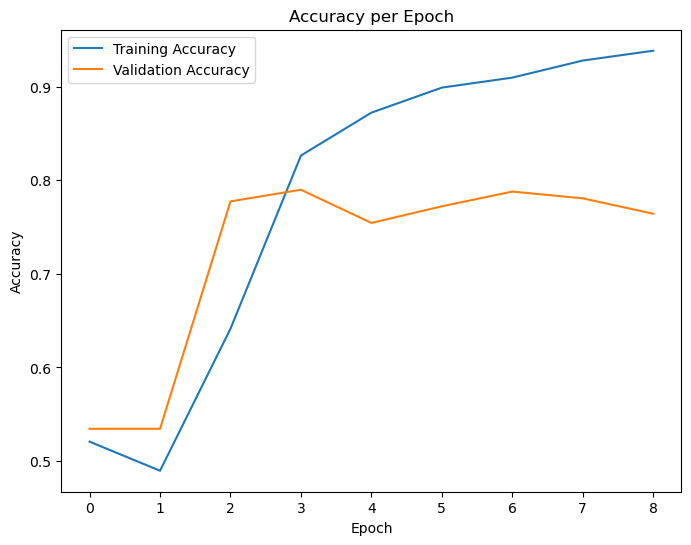

In [267]:
# Print best results
print(f"\nBest Parameters: {best_params}")
print(f"Best Validation F1: {best_val_f1:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(best_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Best Model Performance: The model with embedding_dim=64, lstm_units=32, and learning_rate=0.0005 achieved the highest validation F1 score of 0.7647, demonstrating strong performance on unseen data. It also has a low F1 gap of 0.05582 between training and validation F1, indicating strong generalization. This model’s validation accuracy (0.7898), precision (0.7988), and recall (0.7334) are all among the top performances.

Generalization and Stability: The best model’s small F1 gap highlights its ability to avoid overfitting, unlike models with higher gaps (e.g., 0.1529 for embedding_dim=64, lstm_units=64, learning_rate=0.0001). Models with lower learning rates (0.0005, 0.0001) generally show better generalization, but some (e.g., embedding_dim=64, lstm_units=32, learning_rate=0.0001) underperform on validation F1 (0.2410), likely due to insufficient training.


What Went Well: The grid search effectively identified a balanced model with embedding_dim=64 and lstm_units=32, which consistently outperformed larger architectures in validation F1. Lower learning rates (0.0005) struck a good balance between convergence speed and stability, as seen in the best model’s metrics. The use of early stopping prevented overfitting, particularly for models with smaller F1 gaps.


Areas for Improvement: Adding dropout layers (e.g., 0.2–0.3 after LSTM or Dense layers) could further reduce overfitting in models with larger F1 gaps (e.g., 0.1284 for embedding_dim=64, lstm_units=32, learning_rate=0.0010). Increasing early stopping patience (e.g., from 5 to 10) for lower learning rates (0.0001) might allow better convergence, as some models (e.g., embedding_dim=64, lstm_units=64, learning_rate=0.0001) show high training F1 (0.8958) but poor validation F1 (0.7429). Experimenting with larger LSTM units (e.g., 128) or additional Dense layers could enhance feature extraction, particularly for complex patterns, but should be paired with regularization to maintain generalization.

# Predictions

In [268]:
model = tf.keras.models.load_model('best_model_grid')

In [269]:
predictions = model.predict([test_padded, test_cat])
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to 0/1

test_df['target'] = predictions
test_df[['id', 'target']].to_csv('submission.csv', index=False)

102/102 [==============================] - 1s 5ms/step
